# Машинное обучение, ФКН ВШЭ

## Практическое задание 6. Разложение ошибки на смещение и разброс

### Общая информация

Дата выдачи: 20.11.2020

Мягкий дедлайн: 00:59MSK 02.12.2019

Жесткий дедлайн: 00:59MSK 07.12.2019

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи
Задания сдаются через систему anytask. Посылка должна содержать:
* Ноутбук homework-practice-06-Username.ipynb

Username — ваша фамилия и имя на латинице именно в таком порядке

### О задании

В этом задании вам предстоит воспользоваться возможностями бутстрапа для оценки смещения и разброса алгоритмов машинного обучения. Делать мы это будем на данных boston:

In [90]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.datasets import load_boston
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
boston = load_boston()

In [3]:
X = boston["data"]
y = boston["target"]

In [4]:
X.shape, y.shape

((506, 13), (506,))

### Вычисление bias и variance с помощью бутстрапа
На лекции была выведено следующая формула, показывающая, как можно представить ошибку алгоритма регрессии в виде суммы трех компонент:
$$
L(\mu) = 
    \mathbb{E}_{x, y}\bigl[\mathbb{E}_{X}\bigl[ (y - \mu(X)(x))^2 \bigr]\bigr] = 
$$
$$
    \underbrace{\mathbb{E}_{x, y}\bigl[(y - \mathbb{E}[y|x] )^2\bigr]}_{\text{шум}} + \underbrace{\mathbb{E}_{x}\bigl[(\mathbb{E}_{X}[\mu(X)(x)] - \mathbb{E}[y|x] )^2\bigr]}_{\text{смещение}} +
    \underbrace{\mathbb{E}_{x}\bigl[\mathbb{E}_{X}\bigl[(\mu(X)(x) - \mathbb{E}_{X}[\mu(X)(x)] )^2\bigr]\bigr]}_{\text{разброс}},
$$
* $\mu(X)$ — алгоритм, обученный по выборке $X = \{(x_1, y_1), \dots (x_\ell, y_\ell)\}$;
* $\mu(X)(x)$ — ответ алгоритма, обученного по выборке $X$, на объекте $x$;
* $\mathbb{E}_{X}$ — мат. ожидание по всем возможным выборкам;
* $\mathbb{E}_{X}[\mu(X)(x)]$ — "средний" ответ алгоритма, обученного по всем возможным выборкам $X$, на объекте $x$.
    
С помощью этой формулы мы можем анализировать свойства алгоритма обучения модели $\mu$, если зададим вероятностную модель порождения пар $p(x, y)$.

В реальных задачах мы, конечно же, не знаем распределение на парах объект - правильный ответ. Однако у нас есть набор семплов из этого распределения (обучающую выборка), и мы можем использовать его, чтобы оценивать математические ожидания. Для оценки мат. ожиданий по выборкам мы будем пользоваться бутстрэпом - методом генерации "новых" выборок из одной с помощью выбора объектов с возвращением. Разберем несколько шагов на пути к оценке смещения и разброса.

#### Приближенное вычисление интегралов
На занятиях мы разбирали примеры аналитического вычисления смещения и разброса нескольких алгоритмов обучения. Для большинства моделей данных и алгоритмов обучения аналитически рассчитать математические ожидания в формулах не удастся. Однако мат. ожидания можно оценивать приближенно. Чтобы оценить математическое ожидание $\mathbb{E}_{\bar z} f(\bar z)$ функции от многомерной случайной величины $\bar z = (z_1, \dots, z_d)$, $\bar z \sim p(\bar z)$, можно сгенерировать выборку из распределения $p(\bar z)$ и усреднить значение функции на элементах этой выборки:
$$\mathbb{E}_{\bar z} f(z) = \int f(\bar z) p(\bar z) d \bar z \approx \frac 1 m \sum_{i=1}^m f(\bar z_i), \, \bar z_i \sim p(\bar z), i = 1, \dots, m.$$

Например, оценим $\mathbb{E}_z z^2,$ $z \sim \mathcal{N}(\mu=5, \sigma=3)$ (из теории вероятностей мы знаем, что
$\mathbb{E}_z z^2 = \sigma^2 + \mu^2 = 34$):

In [5]:
z = np.random.normal(loc=5, scale=3, size=1000)
(z**2).mean()

34.72328142252556

#### Оценивание $\mathbb{E}_{x, y}$
Оценить мат. ожидания по $x$ и по $x, y$, встречающиеся во всех трех компонентах разложения, несложно, потому что у нас есть выборка объектов из распределения данных $p(x, y)$:
$$ \mathbb{E}_{x} f(x) \approx \frac 1 N \sum_{i=1}^N f(x_i), \quad
\mathbb{E}_{x, y} f(x, y) \approx \frac 1 N \sum_{i=1}^N f(x_i, y_i),$$
где $N$ - число объектов в выборке, $\{(x_i, y_i)\}_{i=1}^N$ - сама выборка. 

#### Оценивание $\mathbb{E}_X$ с помощью бутстрапа
Чтобы оценить мат. ожидание по $X$, нам понадобится выборка из выборок:
$$\mathbb{E}_X f(X) \approx \frac 1 s \sum_{j=1}^s f(X_j),$$
где $X_j$ - $j$-я выборка. Чтобы их получить, мы можем воспользоваться бутстрапом - методом генерации выборок на основе выбора объектов с возвращением. Чтобы составить одну выборку, будем $N$ раз выбирать индекс объекта $i \sim \text{Uniform}(1 \dots N)$ и добавлять $i$-ю пару (объект, целевая переменная) в выборку. В результате в каждой выборке могут появиться повторяющиеся объекты, а какие-то объекты могут вовсе не войти в некоторые выборки.

#### Итоговый алгоритм оценки смещения и разброса алгоритма $a$
1. Сгенерировать $s$ выборок $X_j$ методом бутстрапа.
1. На каждой выборке $X_j$ обучить алгоритм $a_j$.
1. Для каждой выборки $X_j$ определить множество объектов $T_j$, не вошедших в нее (out-of-bag). Вычислить предсказания алгоритма $a_j$ на объектах $T_j$. 

Поскольку у нас есть только один ответ для каждого объекта, мы будем считать шум равным 0, а $\mathbb{E}[y|x]$ равным имеющемуся правильному ответу для объекта $x$. 

Итоговые оценки:
* Смещение: для одного объекта - квадрат разности среднего предсказания и правильного ответа. Среднее предсказание берется только по тем алгоритмам $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего смещения выполнить усреденение смещений по объектам.
* Разброс: для одного объекта - выборочная дисперсия предсказаний алгоритмов $a_j$, для которых этот объект входил в out-of-bag выборку $T_j$. Для получения общего разброса выполнить усреденение разбросов по объектам.
* Ошибка $L$: усреднить квадраты разностей предсказания и правильного ответа по всем выполненным предсказаниям для всех объектов.

В результате должно получиться, что ошибка приблизительно равна сумме смещения и разброса!

Алгоритм также вкратце описан по [ссылке](https://web.engr.oregonstate.edu/~tgd/classes/534/slides/part9.pdf) (слайды 19-21).

__1. (3 балла)__

Реализуйте описанный алгоритм. Обратите внимание, что если объект не вошел ни в одну из out-of-bag выборок, учитывать его в вычислении итоговых величин не нужно. Как обычно, разрешается использовать только один цикл - по выборкам (от 0 до num_runs-1).

In [54]:
def compute_biase_variance(regressor, X, y, num_runs=1000):
    """
    :param regressor: sklearn estimator with fit(...) and predict(...) method
    :param X: numpy-array representing training set ob objects, shape [n_obj, n_feat]
    :param y: numpy-array representing target for training objects, shape [n_obj]
    :param num_runs: int, number of samples (s in the description of the algorithm)
    
    :returns: bias (float), variance (float), error (float) 
    each value is computed using bootstrap
    """
    whole_idx = range(X.shape[0]) # индексы всех объектов для генерации OOB
    whole_num_runs = range(num_runs) # индексаторы по количеству num_runs для создания датафреймов
    prediction_history = pd.DataFrame(index=whole_idx, columns=whole_num_runs) # здесь храним предсказания моделей в количестве num_runs
    out_of_bag_history = pd.DataFrame(index=whole_idx, columns=whole_num_runs) # здесь храним маркеры попадания объекта в OOB для i-ой модели
    errors = [] # здесь будем хранить ошибку для i-ой модели
    for i in whole_num_runs:
        #if i % 10 == 0:
        #    print("Итерация: " + str(i))
        oob_idx = np.random.choice(range(X.shape[0]), size=X.shape[0])
        in_oob_idx = list(set(range(X.shape[0])) - set(oob_idx))
        X_train = X[oob_idx, :]
        X_test = X[in_oob_idx, :]
        y_train = y[oob_idx]
        y_test = y[in_oob_idx]
        model = regressor.fit(X_train, y_train)
        prediction = model.predict(X_test)
        out_of_bag_history.iloc[in_oob_idx, i] = True
        out_of_bag_history.iloc[oob_idx, i] = False
        prediction_history.iloc[in_oob_idx, i] = prediction
        errors.append(np.mean(np.square(y_test-prediction)))
    bias = ((prediction_history[out_of_bag_history].mean(axis=1) - y)**2).mean()
    means = np.repeat(np.expand_dims(prediction_history[out_of_bag_history].mean(axis = 1), axis=1), repeats=num_runs, axis=1)
    difference = means -  prediction_history[out_of_bag_history] 
    variance = ((difference ** 2).mean()).mean()
    error = np.mean(errors)
    return bias, variance, error

__2. (0 баллов)__

Оцените смещение, разброс и ошибку для трех алгоритмов с гиперпараметрами по умолчанию: линейная регрессия, решающее дерево, случайный лес.

In [7]:
### your code here
models = [LinearRegression(), DecisionTreeRegressor(), RandomForestRegressor()]
results = {}
for model in models:
    print(model)
    results[model] = compute_biase_variance(model, X, y, num_runs=100)

LinearRegression()
Итерация: 0
Итерация: 10
Итерация: 20
Итерация: 30
Итерация: 40
Итерация: 50
Итерация: 60
Итерация: 70
Итерация: 80
Итерация: 90
DecisionTreeRegressor()
Итерация: 0
Итерация: 10
Итерация: 20
Итерация: 30
Итерация: 40
Итерация: 50
Итерация: 60
Итерация: 70
Итерация: 80
Итерация: 90
RandomForestRegressor()
Итерация: 0
Итерация: 10
Итерация: 20
Итерация: 30
Итерация: 40
Итерация: 50
Итерация: 60
Итерация: 70
Итерация: 80
Итерация: 90


In [8]:
for model, data in results.items():
    print(model, ":")
    print("Bias: " + str(data[0]))
    print("Variance: " + str(data[1]))    
    print("Error: " + str(data[2]))
    print()

LinearRegression() :
Bias: 23.915150706449918
Variance: 1.0155795494720905
Error: 25.424848613790246

DecisionTreeRegressor() :
Bias: 10.062401929788674
Variance: 13.034170158846717
Error: 23.018321269241504

RandomForestRegressor() :
Bias: 10.447689319983162
Variance: 2.1589448861739795
Error: 12.596991776414875



__3. (1 балл)__
Проанализируйте полученный результат. Согласуются ли полученные результаты с теми, что мы обсуждали на занятиях (с комментарием)?

__Your answer here:__

- **Линейная регрессия**: Ошибка довольно высока, практически полностью эту ошибку составляет смещение модели. Модель имеет низкий разброс, то есть не имеет большую тендецию к оверфиту и не ведет себя неадекватно на трейне, что в целом присуще линейной регрессии
- **Решающее дерево**: Ошибка практически идентична линейной регрессии, но теперь практически половину ошибки составляет разброс, то есть дерево сильно ошибается на выборке, не соотвествующей обучающей. При этом очевидно, что дерево будет иметь меньшее смещение по отношению к регрессии, ведь одиночное дерево легко переобучается
- **Случайный лес**: Ошибка ощутимо снижается в отличие от обычного дерева и регрессии, при этом смещение практически соответствует смещению одного дерева, а разброс драматически уменьшен из-за использования композиции деревьев.

__4. (1 балл)__
Постройте бэггинг над всеми тремя моделями (линейная регрессия, решающее дерево, случайный лес). Вспомните обсуждение с лекции о том, во сколько раз в теории бэггинг уменьшает разброс базового алгоритма. Выполняется ли это в ваших экспериментах? Если нет, поясните, почему.

__Your answer here:__

В идеальном случае беггинг для n базовых алгоритмов может уменьшить разброс в n раз разброс по сравнению с этим базовым алгоритмом. Достигается это только в случае, когда получающиеся базовые алгоритмы не коррелированы. 

Очевидно, что линейные модели, даже получаемые по бутрстрапированным выборкам, будут достаточно сильно коррелированны между собой, поэтому беггинг над линейной регрессией не дает практически никаких результатов. В случае с одиночными деревьями результат ощутимый, модели сами по себе сложны и получаюся относительно не коррелированными, потому сдвиг не повышается, а разрос ощутимо падает (хоть и не в 10 раз соответственно заявленному при n_estimators=10, а около 4 раз, но всё равно, прирост очень большой). Что же касается беггинга над случайным лесом, здесь ожидаемо мы не видим никаких результатов, ведь случайный лес уже подразумевает беггинг с семплированием признаков, соответственно беггинг над случайным лесом не дает ощутимых приростов.

In [10]:
results = {}
for model in models:
    regressor = BaggingRegressor(base_estimator=model, n_estimators=10)
    results[model] = compute_biase_variance(regressor, X, y, num_runs=100)

Итерация: 0
Итерация: 10
Итерация: 20
Итерация: 30
Итерация: 40
Итерация: 50
Итерация: 60
Итерация: 70
Итерация: 80
Итерация: 90
Итерация: 0
Итерация: 10
Итерация: 20
Итерация: 30
Итерация: 40
Итерация: 50
Итерация: 60
Итерация: 70
Итерация: 80
Итерация: 90
Итерация: 0
Итерация: 10
Итерация: 20
Итерация: 30
Итерация: 40
Итерация: 50
Итерация: 60
Итерация: 70
Итерация: 80
Итерация: 90


In [11]:
for model, data in results.items():
    print(model, ":")
    print("Bias: " + str(data[0]))
    print("Variance: " + str(data[1]))    
    print("Error: " + str(data[2]))
    print()

LinearRegression() :
Bias: 23.955551214878607
Variance: 1.062157137299634
Error: 25.024108006365037

DecisionTreeRegressor() :
Bias: 10.684584049059026
Variance: 3.2515996780210044
Error: 13.747739077847523

RandomForestRegressor() :
Bias: 11.630897686021715
Variance: 1.37397006848461
Error: 13.205120604568588



### Визуализация предсказаний базовых алгоритмов бэггинга

В материалах лекций можно найти изображение, похожее на мишень - визуализация алгоритмов с разным смещением и разным разбросом. В центре "мишени" - правильный ответ, а "попадания" - предсказания алгоритмов, обученных по разным выборкам. Построим похожее изображение на наших данных для трех алгоритмов. Наши "мишени" будут одномерными, потому что мы решаем задачу одномерной регрессии.

__5. (2 балла)__

Реализуйте фукнцию plot_predictions. Она должна выполнять следующие действия:
1. Случайно выбрать num_test_objects пар объект-целевая переменная из выборки X, y. Получится две выборки: маленькая X_test, y_test (выбранные тестовые объекты) и X_train, y_train (остальные объекты).
1. Сгенерировать num_runs выборок методом бутстарапа из X_train, y_train. На каждой выборке обучить алгоритм regressor и сделать предсказания для X_test.
1. Нарисовать scatter-график. По оси абсцисс - объекты тестовой выборки (номера от 0 до num_test_objects-1), по оси ординат - предсказания. В итоге получится num_test_objects столбиков с точками. Для каждого тестового объекта надо отметить одним цветом все предсказания для него, а также черным цветом отметить правильный ответ.
1. Подпишите оси и название графика (аргумент title).

In [49]:
def plot_predictions(ax, regressor, X, y, num_runs=100, num_test_objects=10, title=""):
    """
    plot graphics described above
    """
    ### your code here
    ax.set_ylabel('Предсказание')
    ax.set_xlabel('№ объекта')
    ax.set_title(title)
    test_size = num_test_objects / X.shape[0]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    test_objects_range = range(num_test_objects)
    for i in range(num_runs):
        oob_idx = np.random.choice(range(X_train.shape[0]), size=X_train.shape[0])
        X_oob = X[oob_idx, :]
        y_oob = y[oob_idx]
        regressor.fit(X_oob, y_oob)
        prediction = regressor.predict(X_test)
        ax.scatter(test_objects_range, prediction, color = 'blue')
    ax.scatter(test_objects_range, y_test, s=100, color = 'red', marker='x')    



__6. (0 баллов)__

Нарисуйте графики для линейной регрессии, решающего дерева и случайного леса. Нарисуйте три графика в строчку (это можно сделать с помощью plt.subplot) с одинаковой осью ординат (это важно для понимания масштаба разброса у разных алгоритмов):

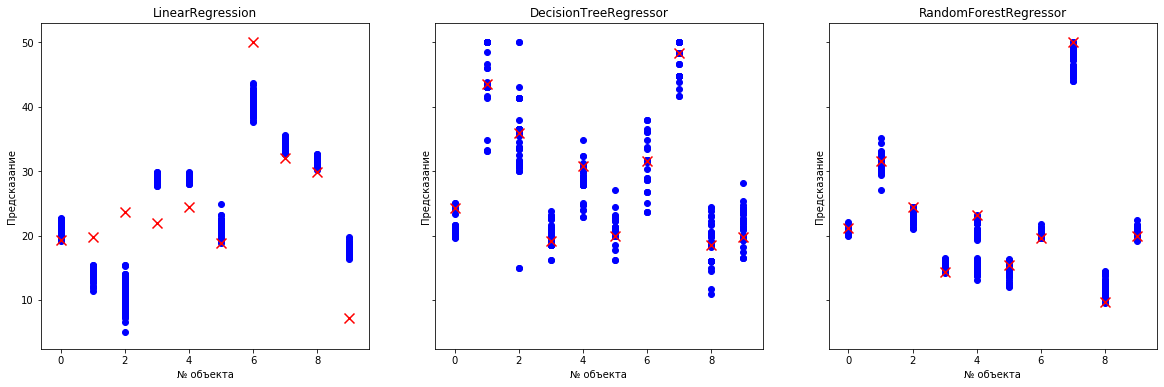

In [52]:
### your code here
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(20, 6))
for i, model in enumerate(models):
    plot_predictions(axs[i], model, X, y, title=model.__class__.__name__)

__7. (1 балл)__

Для каждого графика прокомментируйте, как он характеризует смещение и разброс соответствующего алгоритма. 

__Your answer here:__
По сути, высота получившихся столбиков иллюстрирует то, насколько сильно на одном и том же объекте различаются предсказания (это и есть разброс), а при помощи крестиков (реальных значений таргета) можно прикинуть смещение алгоритма. Исходя из этой логики получаем:
- Линейная регрессия: столбики относительно короткие => разброс невысокий, при этом крестики часто не попадают в столбики и находятся далеко от них => смещение высокое
- Одиночное дерево: столбики достаточно высокие, отдельные точки далеко от столбиков => большой разброс, при этом крестики всегда попадают в эти столбики => смещение невысокое
- Случайный лес: столбики не такие высокие, как для одиночных деревьев, соизмеримы с линрегом => невысокий разброс, крестики всегда попадают в столбики => смещение так же невысоко

### Изменение bias и variance при изменении гиперпараметров

__8. (0 баллов)__

Постройте графики зависимости смещения и разброса от гиперпараметров решающего дерева max_depth (от 1 до 10) и max_features (от 1 до X.shape[1]):

In [57]:
### your code here
depth_results = []
depth_params = range(1, 11)
for depth in depth_params:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_depth = depth), X, y, num_runs=100)
    depth_results.append((bias, variance))

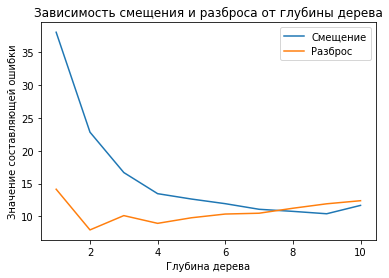

In [82]:
data = pd.DataFrame(depth_results, columns=["Смещение", "Разброс"])
plt.plot(depth_params, data.iloc[:, 0], label="Смещение")
plt.plot(depth_params, data.iloc[:, 1], label="Разброс")
plt.legend()
plt.xlabel("Глубина дерева")
plt.ylabel("Значение составляющей ошибки")
plt.title("Зависимость смещения и разброса от глубины дерева")
plt.show()

In [83]:
max_features_results = []
max_features_params = range(1, X.shape[1])
for max_features in max_features_params:
    bias, variance, error = compute_biase_variance(DecisionTreeRegressor(max_features = max_features), X, y, num_runs=100)
    max_features_results.append((bias, variance))

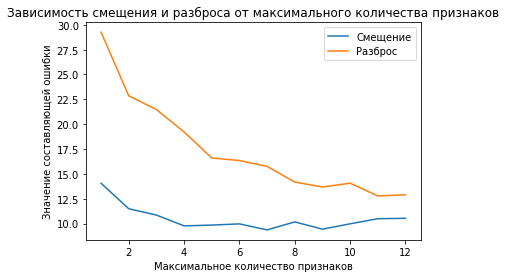

In [89]:
data = pd.DataFrame(max_features_results, columns=["Смещение", "Разброс"])
plt.plot(max_features_params, data.iloc[:, 0], label="Смещение")
plt.plot(max_features_params, data.iloc[:, 1], label="Разброс")
plt.legend()
plt.xlabel("Максимальное количество признаков")
plt.ylabel("Значение составляющей ошибки")
plt.title("Зависимость смещения и разброса от максимального количества признаков")
plt.show()

__9. (0 баллов)__

Постройте графики зависимости смещения и разброса от n_estimators (по сетке 2**np.arange(1, 10)) для случайного леса и градиентного бустинга:

Рассмотрим графики на логарифмической шкале

In [93]:
### your code here
n_estimators_params = 2 ** np.arange(1, 10)
random_forest_results = []
gradient_boosting_results = []

for n_estimators in n_estimators_params:
    print("Estimators: " + str(n_estimators))
    bias, variance, error = compute_biase_variance(GradientBoostingRegressor(n_estimators = n_estimators), X, y, num_runs=100)
    gradient_boosting_results.append((bias, variance))
    bias, variance, error = compute_biase_variance(RandomForestRegressor(n_estimators = n_estimators), X, y, num_runs=100)
    random_forest_results.append((bias, variance))

Estimators: 2
Estimators: 4
Estimators: 8
Estimators: 16
Estimators: 32
Estimators: 64
Estimators: 128
Estimators: 256
Estimators: 512


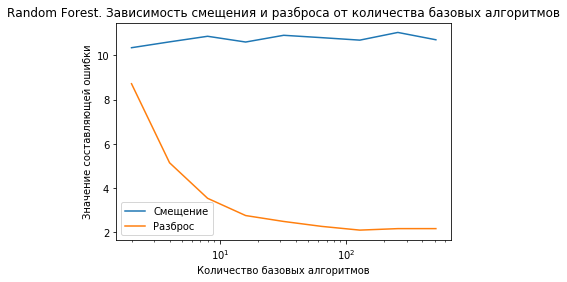

In [102]:
data = pd.DataFrame(random_forest_results, columns=["Смещение", "Разброс"])
plt.plot(n_estimators_params, data.iloc[:, 0], label="Смещение")
plt.plot(n_estimators_params, data.iloc[:, 1], label="Разброс")
plt.xscale('log')
plt.legend()
plt.xlabel("Количество базовых алгоритмов")
plt.ylabel("Значение составляющей ошибки")
plt.title("Random Forest. Зависимость смещения и разброса от количества базовых алгоритмов")
plt.show()

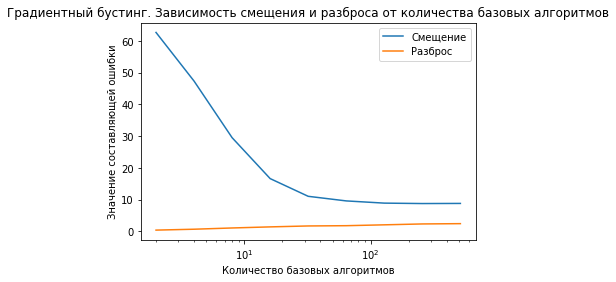

In [103]:
data = pd.DataFrame(gradient_boosting_results, columns=["Смещение", "Разброс"])
plt.plot(n_estimators_params, data.iloc[:, 0], label="Смещение")
plt.plot(n_estimators_params, data.iloc[:, 1], label="Разброс")
plt.legend()
plt.xscale('log')
plt.xlabel("Количество базовых алгоритмов")
plt.ylabel("Значение составляющей ошибки")
plt.title("Градиентный бустинг. Зависимость смещения и разброса от количества базовых алгоритмов")
plt.show()

__10. (2 балла)__

Прокомментируйте графики (всего 4 графика): почему они имеют такой вид.

__Your answer here:__

- Зависимость смещения и разброса от глубины дерева: очевидно, что чем больше глубина дерева, тем более сложным это дерево получается, соответственно, тем лучше дерево способно подогнаться под выборку, тем самым уменьшая смещение. В таком случае также очевидно, что с увеличением глубины (а следовательно, и сложности) дерева будет увеличиваться его разброс.


- Зависимость смещения и разброса от максимального количества признаков для решающего дерева: чем больше признаков охватывается при выборе предиката во время обучения дерева, тем больше шансов точно предсказать таргет. При этом наблюдается ситуация, что при добалении признаков начиная с определенного порога (в нашем случае, с 7 признаков) смещение начинает расти. Это может говорить о том, что признаки, которые добавляются после 7, не самые лучшие с точки зрения качества модели. Разброс стабильно уменьшается, что может говорить о том, что деревья, использующие малое количество признаков, больше склонны к переобучению.


- Зависимость смещения и разброса от количества базовых алгоритмов для случайного леса: смещение модели остается приблизительно постоянным, поскольку при построении случайного леса разброс композиции соответствует разбросу одного базового алгоритма. При этом с добавлением большего количества алгоритмов в композицию разброс падает, но начиная с 128 алгоритмов изменения становятся несущественными. 

- Зависимость смещения и разброс от количества базовых алгоритмов для градиентного бустинга: смещение модели начинается с очень больших значений для малого количестова базовых алгоритмов, поскольку для бустинга в качестве первых базовых алгоритмов берутся простые модели, плохо предсказывающие таргет. При этом начиная с определенных значений (в нашем случае - с 64) смещение перестает ощутимо уменьшаться. Разброс композиции остается достаточно низким, поскольку в композиции используются простые алгоритмы. 